                                 filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  xa.s12.00.mhz.1970-06-26HR00_evid00009     1970-06-26T20:03:21.323547   

   time_rel(sec)  
0   72201.207547  
1970-06-26 20:03:21.323547
72201.2075471698
xa.s12.00.mhz.1970-06-26HR00_evid00009
       time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0          1970-06-26T00:00:00.116000       0.000000  -6.727977e-16
1          1970-06-26T00:00:00.266943       0.150943  -8.646711e-16
2          1970-06-26T00:00:00.417887       0.301887  -9.298738e-16
3          1970-06-26T00:00:00.568830       0.452830  -8.589095e-16
4          1970-06-26T00:00:00.719774       0.603774  -7.139047e-16
...                               ...            ...            ...
572418     1970-06-27T00:00:02.832981   86402.716981   5.039820e-17
572419     1970-06-27T00:00:02.983925   86402.867925  -9.191068e-18
572420     1970-06-27T00:00:03.134868   86403.018868  -2.796955e-17
572421     1970-06-27T00:00:03.285811   86403.

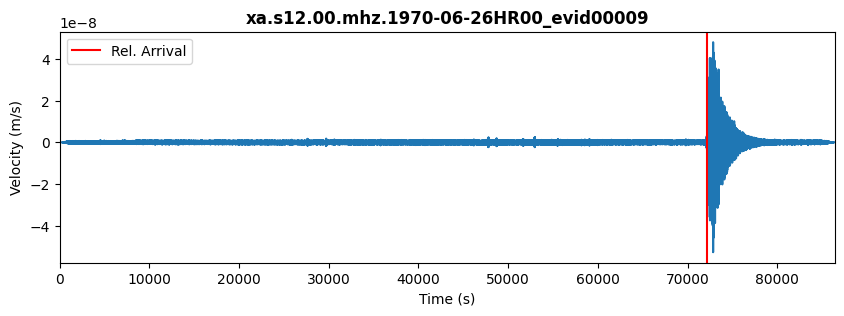

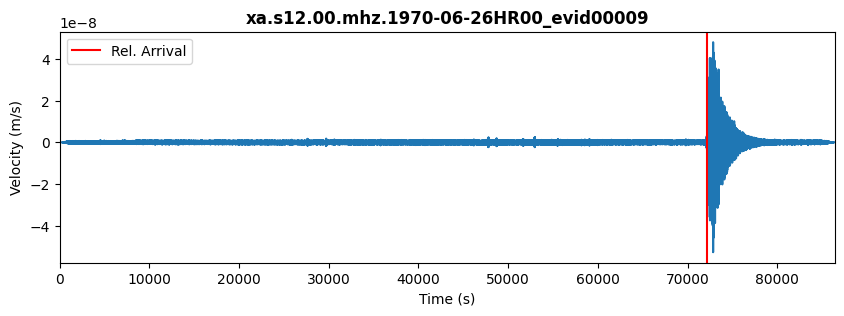

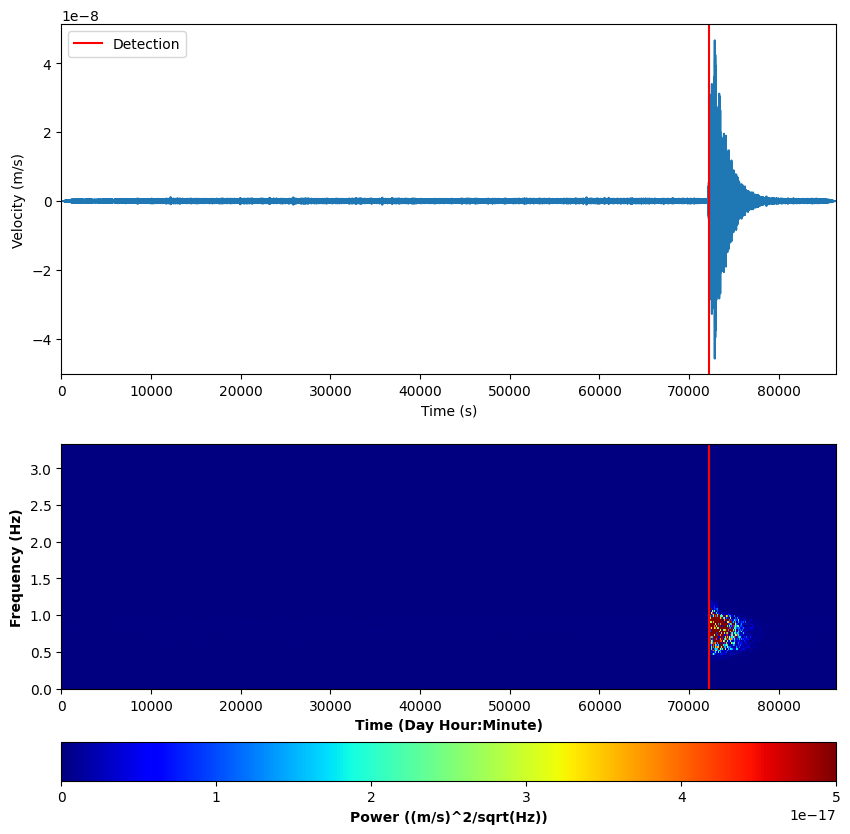

In [3]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


#List the files in the catalog
cat_directory = './data/lunar/'
cat_file = cat_directory + 'filteredxa.s12.00.mhz.1970-06-26HR00_evid00009.csv'
cat = pd.read_csv(cat_file)
print(cat)

#Select a file from the catalog
row = cat.iloc[0]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
print(arrival_time)

# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
print(arrival_time_rel)

# Let's also get the name of the file
test_filename = row.filename
print(test_filename)

# Read the CSV
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
print(data_cat)

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

#read the miniseed file
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
print(st)

# The stream file also contains some useful header information
print(st[0].stats)

# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
print(arrival)

# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Filtering the signal
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

# To better see the patterns, we will create a spectrogram using the scipy function
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')